In [66]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from pmdarima.arima import auto_arima
from sklearn.metrics import root_mean_squared_error
import pickle


In [67]:
df = pd.read_csv("../dataset.csv", index_col="ts", parse_dates = True)
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


In [68]:
df = df.resample('D').mean()
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02,46.0,27.144790,33.753629,3158.710145,62.623188,31.623188,0.000000,87.246377
2025-04-03,128.5,25.908357,33.485352,3121.473958,76.322917,29.742708,0.025000,81.854167
2025-04-04,224.5,25.931506,33.122399,3223.473958,72.354167,30.153125,0.000000,36.416667
2025-04-05,320.0,141.128589,33.805593,3099.052632,71.084211,30.283158,0.000000,63.873684


In [69]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end]
test_data = df[train_end:test_end]

# Training sarima to predict the temperature 

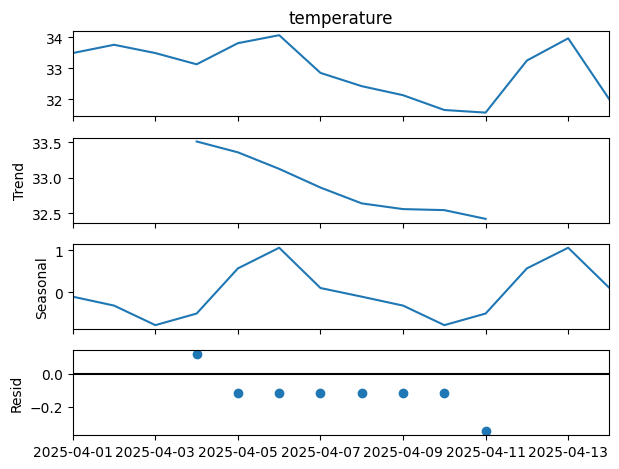

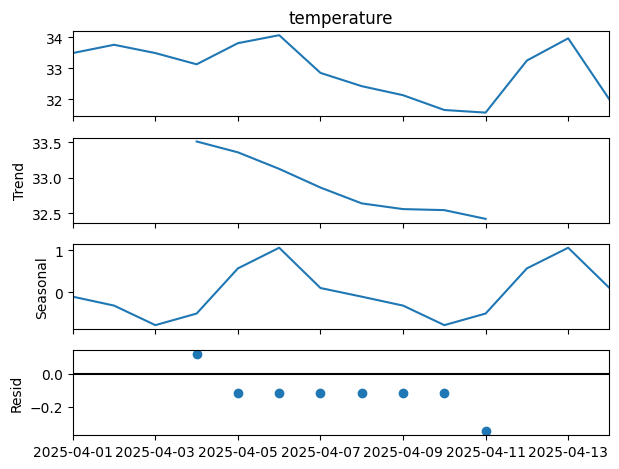

In [70]:
seasonal_decompose(df["temperature"], model="additive").plot()

## Find the D parameter

In [71]:
result = adfuller(df["temperature"].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: 0.386629965898856
p-value: 0.9809880068337415
Critial Values:
   1%, -4.6651863281249994
Critial Values:
   5%, -3.3671868750000002
Critial Values:
   10%, -2.802960625


The ADF statistics value is less than 0.05, therefore, it is stationary.

## Find the P parameter

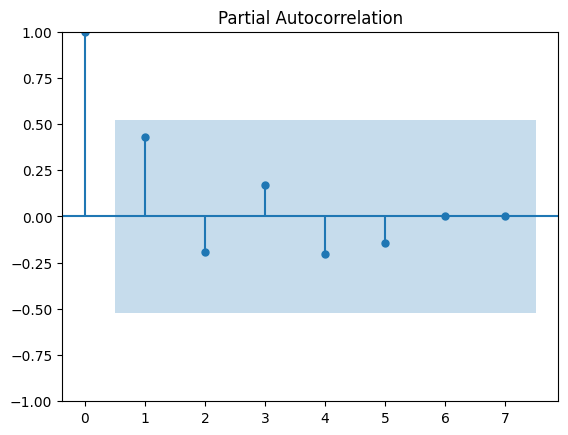

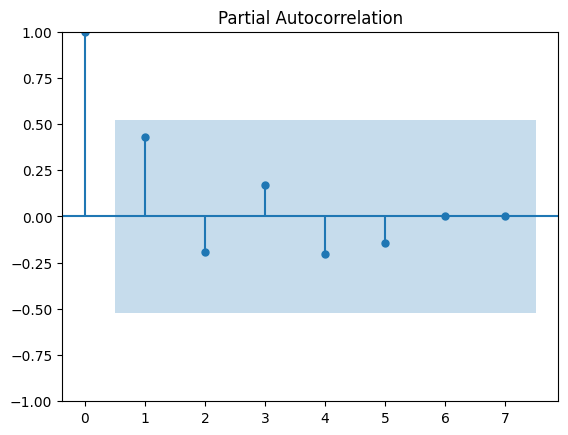

In [72]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["temperature"])

The two lags in the front are the most influential, therefore, p = 2

## Find the Q parameter

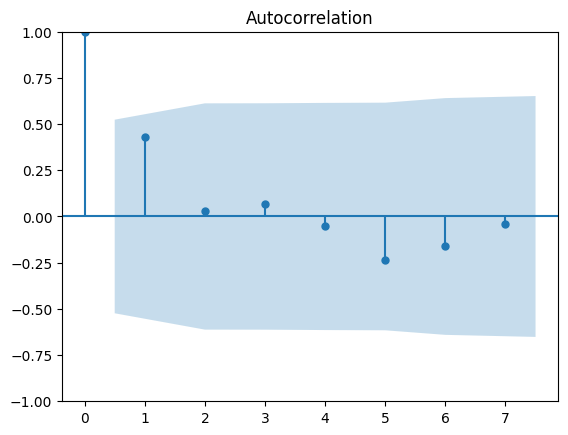

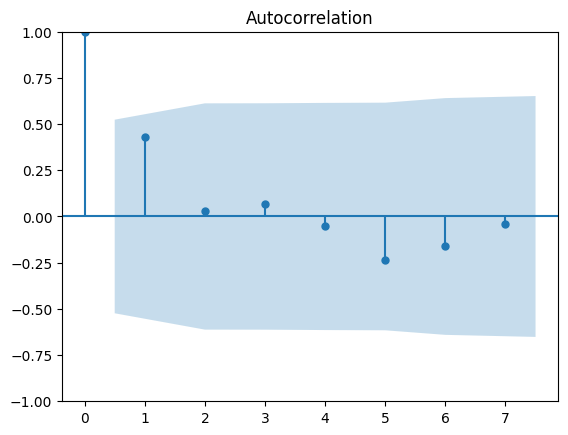

In [73]:
plot_acf(df["temperature"])

The graph is not clear, therefore, the q parameter might be 0 or 1

## Train the model

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


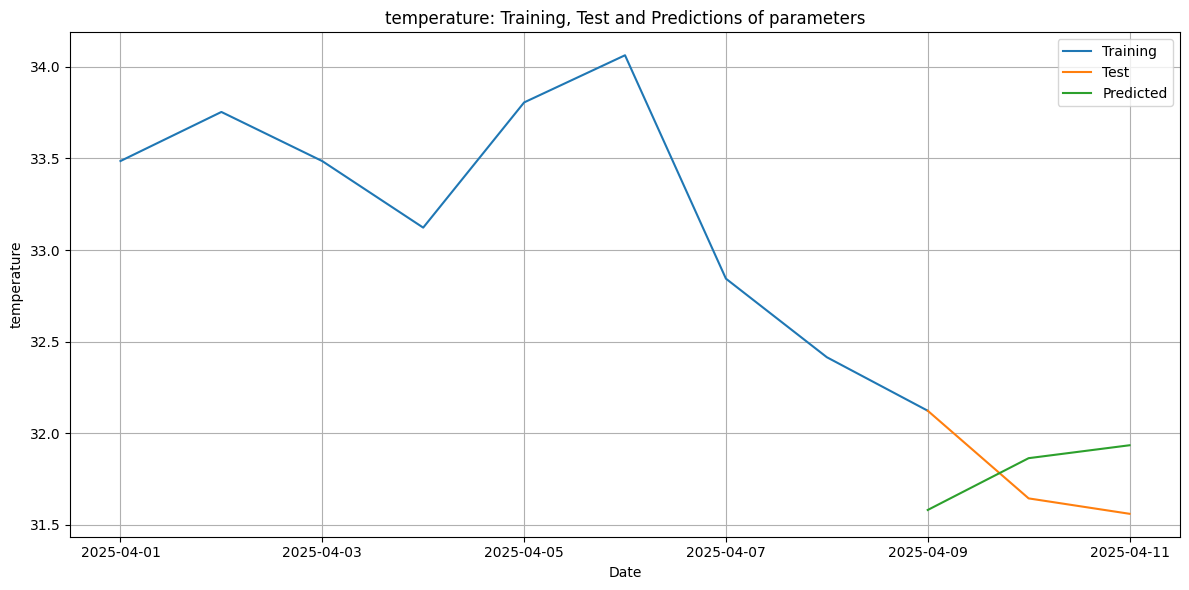

RMSE is :  0.40059208959683507


In [74]:
model_temperature = SARIMAX(
    endog=train_data['temperature'],
    order=(1,0,1),
    seasonal_order=(1,0,1,3)
)
temperature_results = model_temperature.fit()


temperature_prediction = temperature_results.get_forecast(steps = int(test_data['temperature'].count())).predicted_mean
forecast_index = pd.date_range(
            start=test_data.index[0],
            freq=timedelta(days=1),
            periods=int(test_data['temperature'].count()),
        )
temperature_prediction.columns = ['predicted']

plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["temperature"], label="Training")
plt.plot(test_data.index, test_data["temperature"], label="Test")
plt.plot(test_data.index, temperature_prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("temperature")
plt.title(f"temperature: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE is : ", root_mean_squared_error(test_data['temperature'], temperature_prediction))

## Save the model using pickle

In [75]:
with open('../exports/temperature_sarima.pkl', 'wb') as file:
    pickle.dump(temperature_results, file)

# Training sarima to predict the temperature 

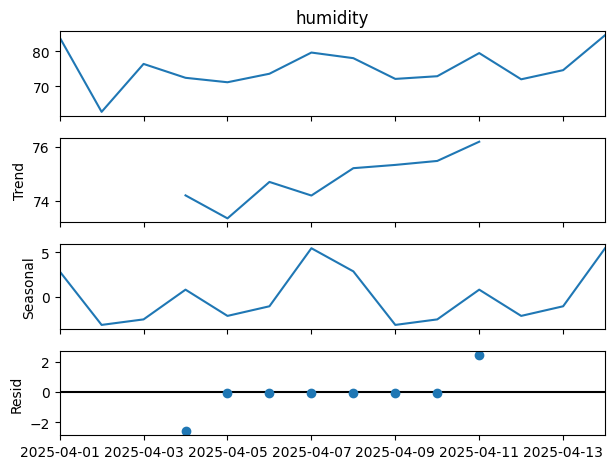

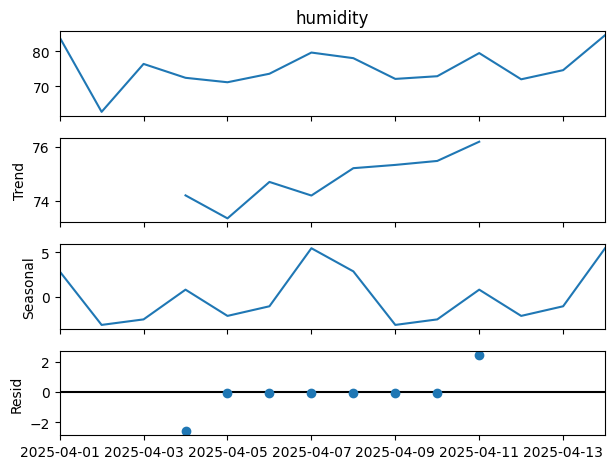

In [76]:
seasonal_decompose(df["humidity"], model="additive").plot()

## Find the D parameter

In [77]:
result = adfuller(df["humidity"].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -1.2250252305697786
p-value: 0.6627389242204811
Critial Values:
   1%, -4.331573
Critial Values:
   5%, -3.23295
Critial Values:
   10%, -2.7487


The ADF statistics value is less than 0.05, therefore, it is stationary.

## Find the P parameter

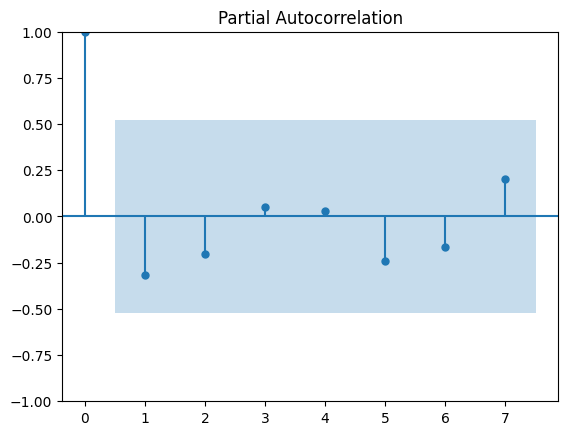

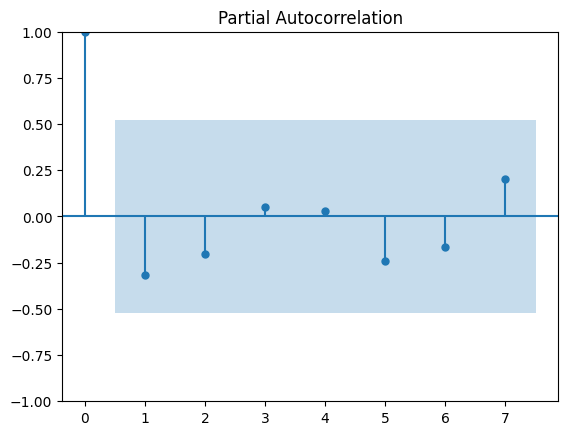

In [78]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["humidity"])


The 4 lags in the front are the most influential, therefore, p = 4

## Find the Q parameter

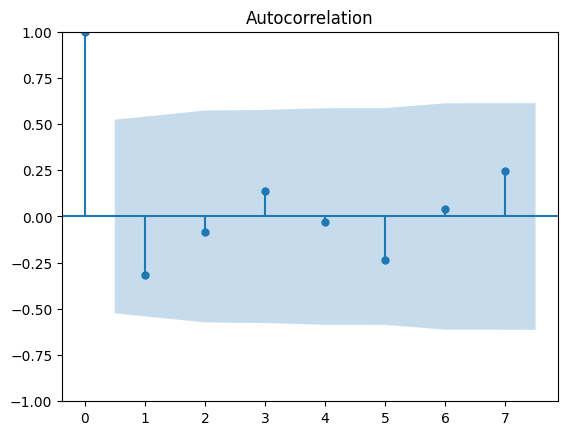

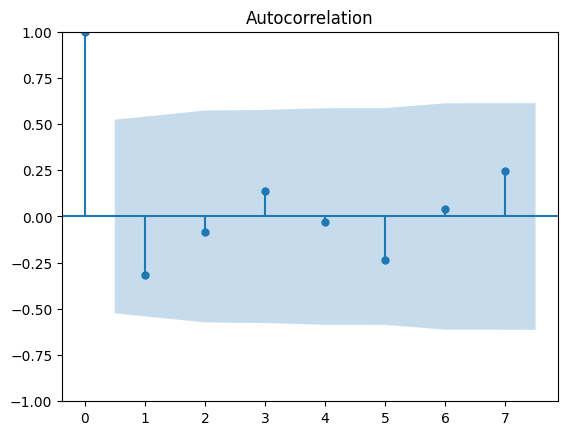

In [79]:
plot_acf(df["humidity"])

The graph is not clear, therefore, the q parameter might be 0 or 1

## Train the model

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


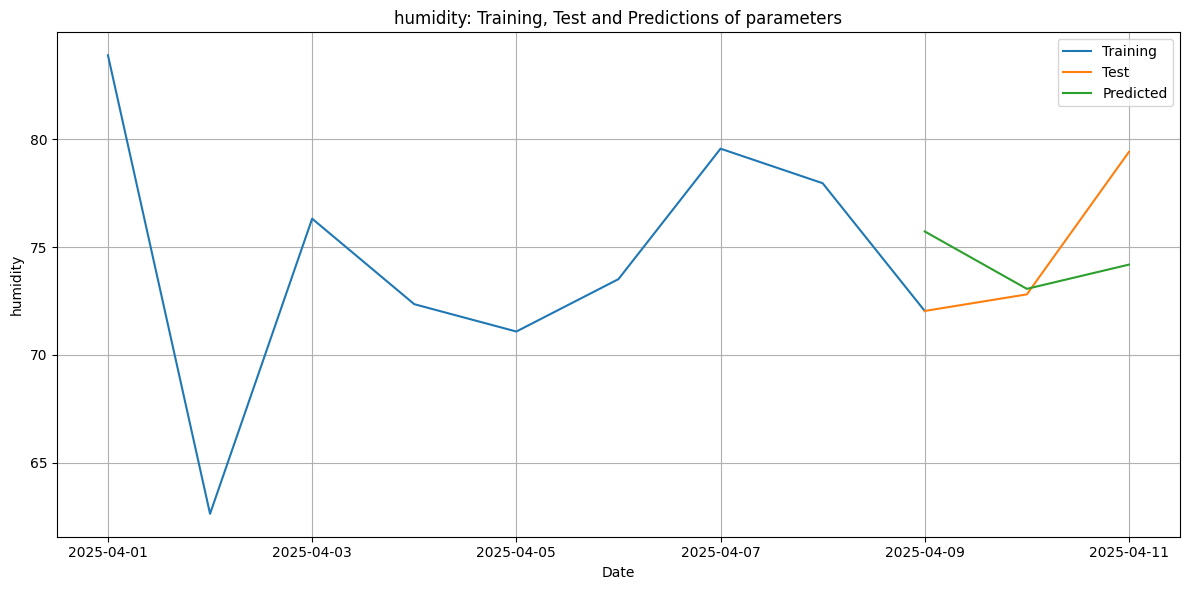

RMSE is :  3.699920326062557


In [80]:
model_humidity = SARIMAX(
    endog=train_data['humidity'],
    order=(1,0,1),
    seasonal_order=(1,0,1,3)
)
humidity_results = model_humidity.fit()

humidity_prediction = humidity_results.get_forecast(steps = int(test_data['humidity'].count())).predicted_mean
forecast_index = pd.date_range(
            start=test_data.index[0],
            freq=timedelta(days=1),
            periods=int(test_data['humidity'].count()),
        )
humidity_prediction.columns = ['predicted']

plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["humidity"], label="Training")
plt.plot(test_data.index, test_data["humidity"], label="Test")
plt.plot(test_data.index, humidity_prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("humidity")
plt.title(f"humidity: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE is : ", root_mean_squared_error(test_data['humidity'], humidity_prediction))

## Save the model using pickle

In [81]:
with open('../exports/humidity_sarima.pkl', 'wb') as file:
    pickle.dump(humidity_results, file)

# Training sarima to predict the temperature 

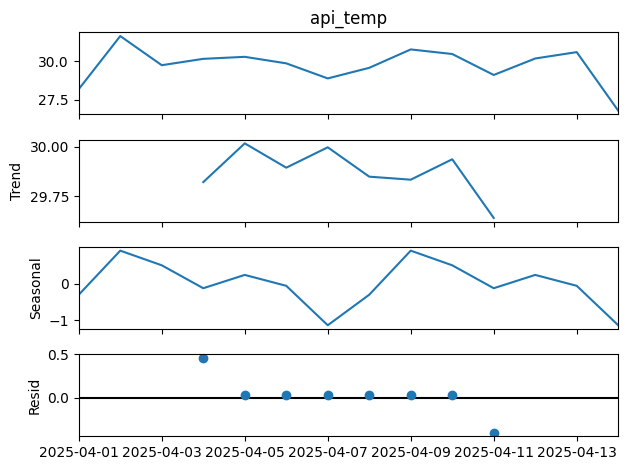

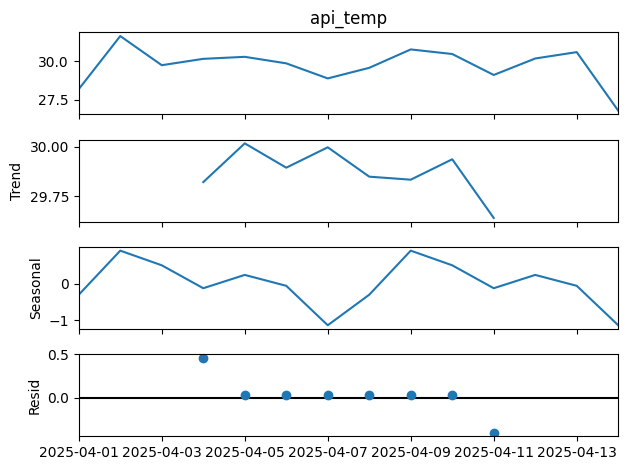

In [82]:
seasonal_decompose(df["api_temp"], model="additive").plot()

## Find the D parameter

In [83]:
result = adfuller(df["api_temp"].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -1.6046739772129046
p-value: 0.4812451879666485
Critial Values:
   1%, -4.473135048010974
Critial Values:
   5%, -3.28988060356653
Critial Values:
   10%, -2.7723823456790124


The ADF statistics value is less than 0.05, therefore, it is stationary.

## Find the P parameter

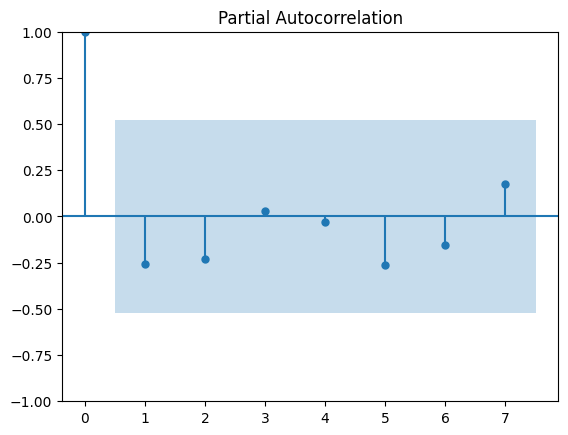

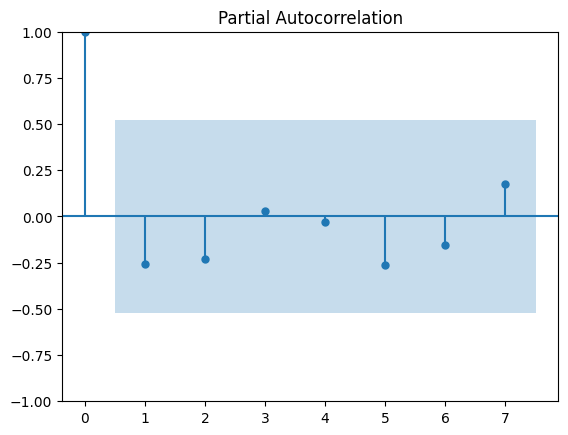

In [84]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["api_temp"])

The three lags in the front are the most influential, therefore, p = 3

## Find the Q parameter

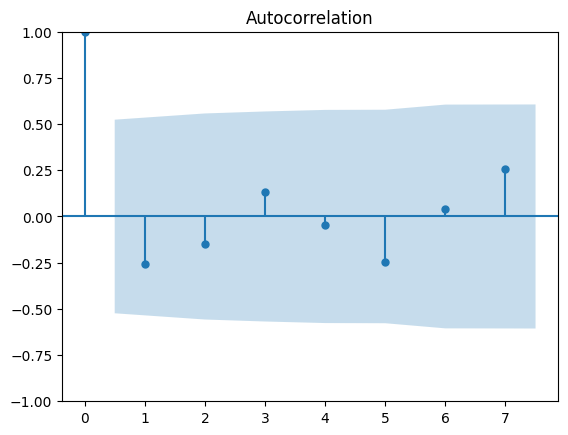

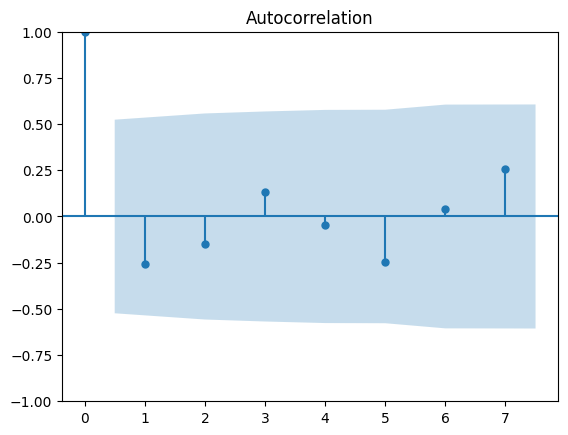

In [85]:
plot_acf(df["api_temp"])

The graph is not clear, therefore, the q parameter might be 0 or 1

## Train the model

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2025-04-10    29.483556
2025-04-11    30.195454
2025-04-12    30.008515
Freq: D, Name: predicted_mean, dtype: float64


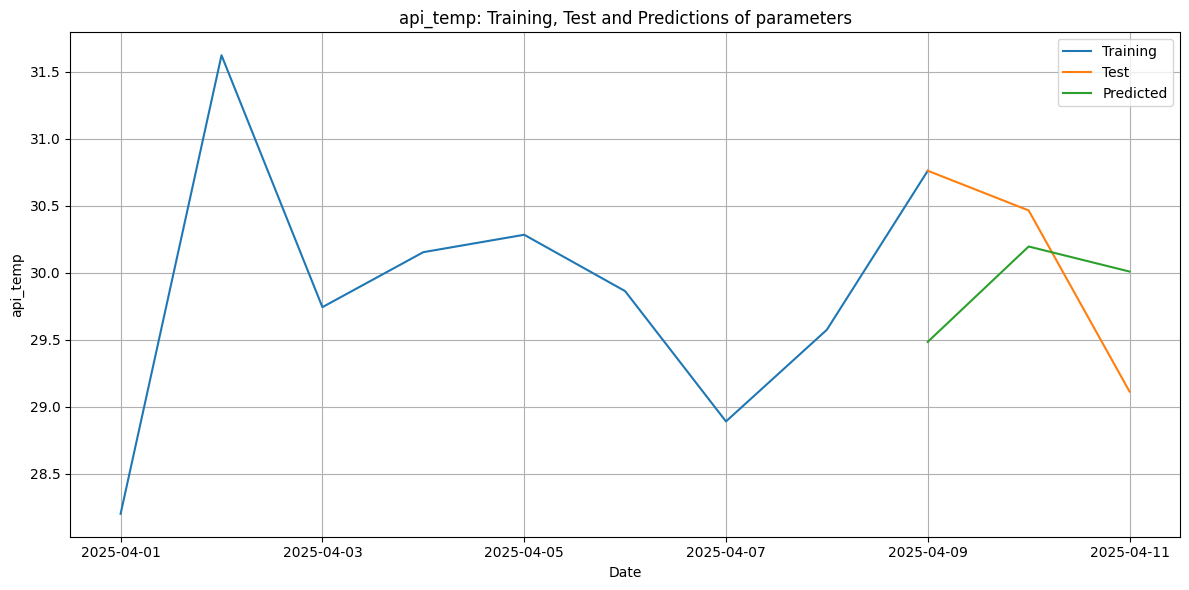

RMSE is :  0.9142454585400088


In [86]:
model_api_temp = SARIMAX(
    endog=train_data['api_temp'],
    order=(1,0,1),
    seasonal_order=(1,0,1,3)
)
api_temp_results = model_api_temp.fit()

api_temp_prediction = api_temp_results.get_forecast(steps = int(test_data['api_temp'].count())).predicted_mean
forecast_index = pd.date_range(
            start=test_data.index[0],
            freq=timedelta(days=1),
            periods=int(test_data['api_temp'].count()),
        )
api_temp_prediction.columns = ['predicted']

print(api_temp_prediction)

plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["api_temp"], label="Training")
plt.plot(test_data.index, test_data["api_temp"], label="Test")
plt.plot(test_data.index, api_temp_prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("api_temp")
plt.title(f"api_temp: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE is : ", root_mean_squared_error(test_data['api_temp'], api_temp_prediction))

## Save the model using pickle

In [87]:
with open('../exports/api_temp_sarima.pkl', 'wb') as file:
    pickle.dump(api_temp_results, file)